In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.optimize import curve_fit


In [18]:
# Global parameters (don't change)
system_symmetry = 6.
MS = torch.arange(2*system_symmetry)
ANGLES = torch.arange(0, system_symmetry) * 2 * torch.pi / system_symmetry
print(MS)
print(ANGLES)
# Extract data_theta, doesn't matter what image is extracted since we're just getting theta
DATA = np.load('/Users/cadenmyers/billingelab/dev/skyrmion_lattices/experimental_data/npz_temp_sweep/image_theta.npz')['data']
DATA_THETA = torch.atan2(torch.tensor(DATA[1]), torch.tensor(DATA[0]))
# Global parameters for model (usually we don't need to change this)
MAX_ITER_OFFSET = 101
LR = 1e-2
# OFFSET_ADJUSTMENT = 60


tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])
tensor([0.0000, 1.0472, 2.0944, 3.1416, 4.1888, 5.2360])


In [19]:
# Import images from .npz files
# Extract data file paths
file_path = "/Users/cadenmyers/billingelab/dev/skyrmion_lattices/experimental_data/"

# TEMP SWEEP MOVIES
# movies = ['121855.npz', '118923.npz', '119486.npz', '119996.npz', '120506.npz', '121016.npz', '121405.npz', '121550.npz', '122365.npz', '122875.npz']

# FIELD SWEEP MOVIES OLD
movies = ['Field_29mT.npz', 'Field_31mT.npz', 'Field_32mT.npz', 'Field_33mT.npz', 'Field_37mT.npz']

#SEPT DATA TEMP SWEEP
movies = ['npz_sept_data/npz_field_sweep/pos29mT_553_50mW.npz']
# movies = ['neg23mT_553_50mW.npz', 'neg23mT_558_25mW.npz', 'neg25mT_553_50mW.npz', 'neg25mT_558_25mW.npz', 'neg27mT_553_50mW.npz', 
#           'neg27mT_558_25mW.npz', 'neg29mT_553_50mW.npz', 'neg29mT_558_25mW.npz', 'neg31mT_553_50mW.npz', 'neg31mT_558_25mW.npz', 
#           'neg33mT_553_50mW.npz', 'neg33mT_558_25mW.npz', 'neg35mT_553_50mW.npz', 'pos23mT_553_50mW.npz', 'pos23mT_558_25mW.npz', 
#           'pos25mT_553_50mW.npz', 'pos25mT_558_25mW.npz', 'pos27mT_553_50mW.npz', 'pos27mT_558_25mW.npz', 'pos29mT_553_50mW.npz', 
#           'pos29mT_558_25mW.npz', 'pos31mT_553_50mW.npz', 'pos31mT_558_25mW.npz', 'pos33mT_553_50mW.npz', 'pos33mT_558_25mW.npz']

# Define the movie you want to run GD and GS on as gif (gif = movies[i])
gif = movies[0]
print(gif)

movie = np.load(file_path + gif)
intensity_data = torch.tensor(movie['data'])

# Parameters:
#   iterations: Number of iterations to run the diffusion process.
#   kappa: Threshold for edge stopping (higher means less edge detection).
#   gamma: Step size (controls diffusion speed).
niter=50
kappa=30
gamma=.1
# intensity_data = torch.tensor(anisotropic_diffusion(intensity_data, niter=niter, kappa=kappa, gamma=gamma))``

print('Tensor shape should be (X,128,128), where X is the number of images.')
print(intensity_data.shape)

npz_sept_data/npz_field_sweep/pos29mT_553_50mW.npz
Tensor shape should be (X,128,128), where X is the number of images.
torch.Size([299, 128, 128])


In [20]:
# Normalize data
def normalize_min_max(data):
    if isinstance(data, torch.Tensor):
        array = data.detach().numpy()
    else:
        array = data
    array_min = np.min(array)
    array_max = np.max(array)
    norm_array = (array - array_min) / (array_max - array_min)
    if isinstance(data, torch.Tensor):
        norm_tensor = torch.tensor(norm_array)
        return norm_tensor
    else:
        return norm_array

In [21]:
k = 3
n_folds = 6
def filter_function(k, theta, n_folds=n_folds):
    filter = torch.exp(k * torch.log((torch.cos(n_folds / 2 * theta))**2))
    return filter

In [22]:
def gradient_descent_optimize_offset(intensity, offset, k=k):
    opt = torch.optim.Adam([offset], lr=LR)
    for i in range(MAX_ITER_OFFSET):
        evaluate_image_theta = torch.exp( k * torch.log( (torch.cos(3 * (DATA_THETA + offset)))**2 ) )
        loss = -(intensity * evaluate_image_theta).sum()
        opt.zero_grad()
        loss.backward()
        opt.step()
    return offset, evaluate_image_theta, loss

/var/folders/2v/z3xfrmpn6dbcyt913rndt0jr0000gn/T/ipykernel_6977/2247224618.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  offset1 = torch.tensor(offset1, requires_grad=True)


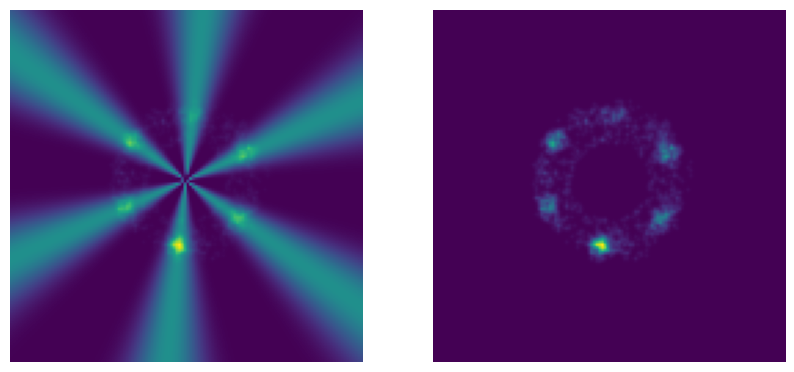

10s:
loss =  -1.65e+05
offset = 5.846540757353834


In [23]:
offset_list = []
loss_list = []
time_list = []
offset1 = torch.tensor(0.0, requires_grad=True)
images_list = []


for index, image in enumerate(intensity_data[:1]):
    # Perform gradient descent optimization
    offset1, filter, loss = gradient_descent_optimize_offset(image, offset1, k=k)
    offset1 = torch.tensor(offset1, requires_grad=True)

    # plotting
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(filter.detach() + normalize_min_max(image))
    axes[0].axis('off')

    axes[1].imshow(image)
    axes[1].axis('off')

    plt.show()

    print(f'{(index + 1) * 10}s:')
    print('loss = ', f'{loss.item():.2e}')
    print("offset =", np.rad2deg(offset1.item()))
    loss_list.append(loss.detach().numpy())
    offset_list.append(offset1)
    time_list.append((index + 1) * 10)



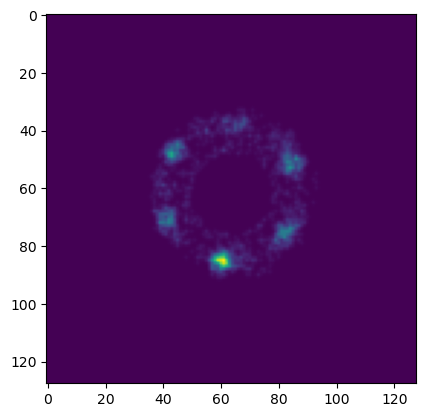

In [24]:
time = 10
index = int(time / 10 - 1)
plt.imshow(intensity_data[index])

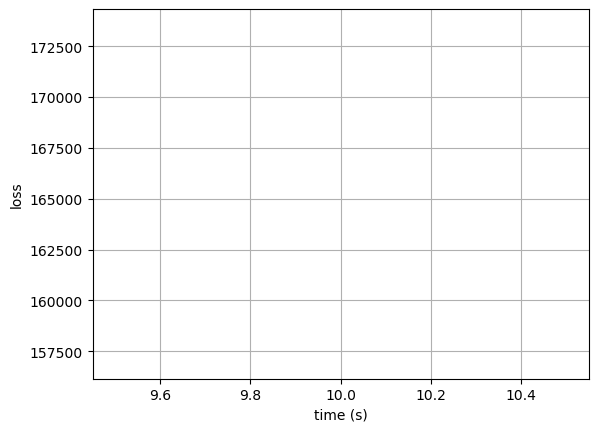

In [25]:
from scipy.signal import find_peaks

plt.plot(time_list, -np.array(loss_list))
plt.ylabel('loss')
plt.xlabel('time (s)')
# plt.xlim(1550, 1750)

# plt.ylim(70000, 500000)
plt.grid(True)

In [52]:
# GET INTENSITY VS THETA, SUMMING INTENSITY RADIALLY

def get_intensity_vs_theta(image, num_bins=360):
    """
    Returns the intensity summed radially as a function of theta.

    Args:
        image (np.array): 2D numpy array representing the image.
        num_bins (int): Number of angular bins to use (default is 360 for each degree).

    Returns:
        theta_bins (np.array): Array of theta values in degrees.
        intensity_sum_per_theta (np.array): Array of summed intensities for each theta bin.
    """
    # Get the image dimensions
    rows, cols = image.shape
    
    # Find the center of the image (assuming symmetry around the center)
    center_x, center_y = rows // 2, cols // 2
    
    # Create meshgrid for pixel coordinates
    y, x = np.indices((rows, cols))
    
    # Convert to polar coordinates (r, theta)
    r = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    theta = np.arctan2(y - center_y, x - center_x)  # Angle in radians
    
    # Convert theta to degrees [0, 360]
    theta_deg = np.rad2deg(theta) % 360
    
    # Define the angular bins
    theta_bins = np.linspace(0, 360, num_bins)
    
    # Initialize array to store radial sums for each angular bin
    intensity_sum_per_theta = np.zeros(num_bins)
    
    # Bin the intensities by theta
    for i in range(num_bins - 1):
        # Find pixels that fall into the current theta bin
        bin_mask = (theta_deg >= theta_bins[i]) & (theta_deg < theta_bins[i + 1])
        
        # Sum the intensity values radially for the current theta bin
        intensity_sum_per_theta[i] = image[bin_mask].sum()
    
    return theta_bins[:-1], intensity_sum_per_theta[:-1]



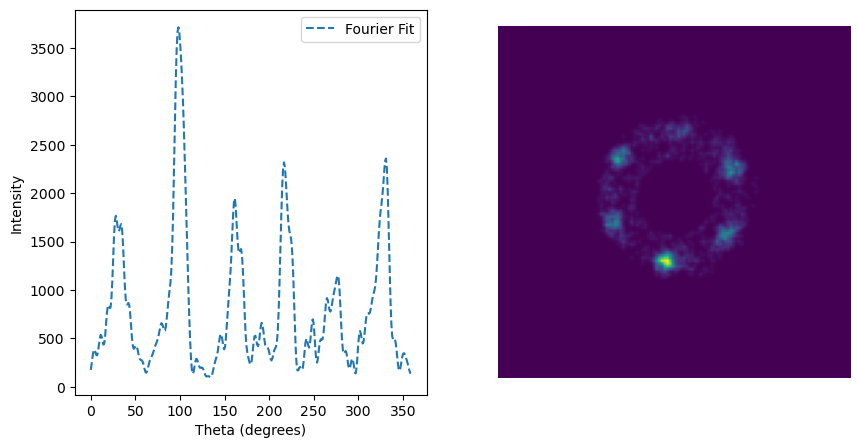

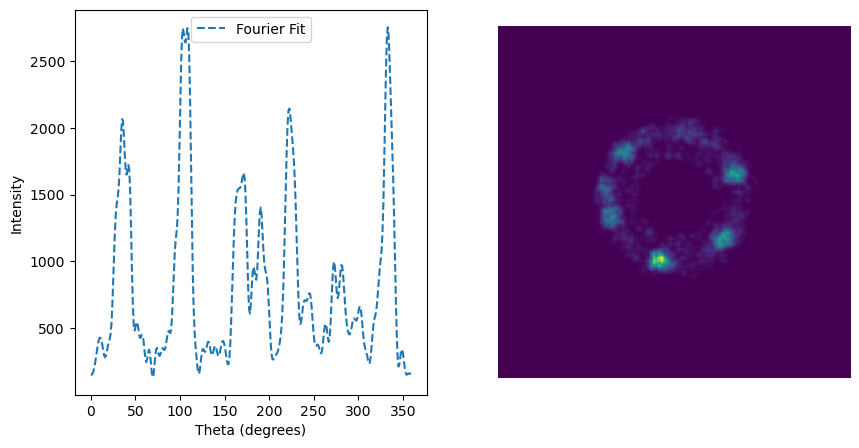

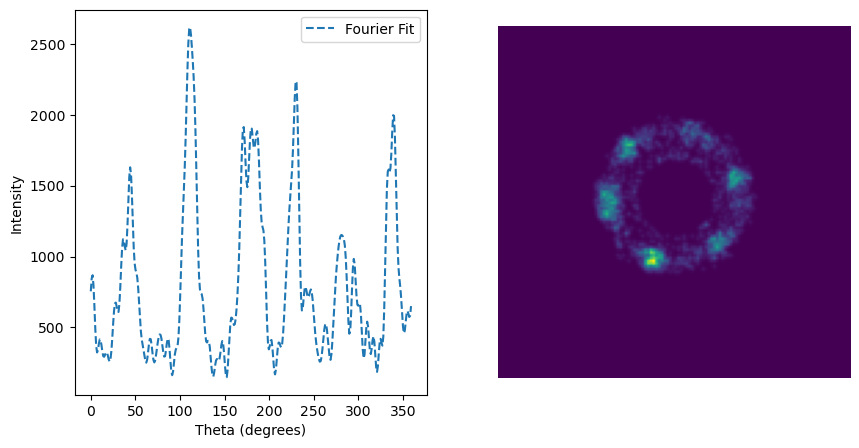

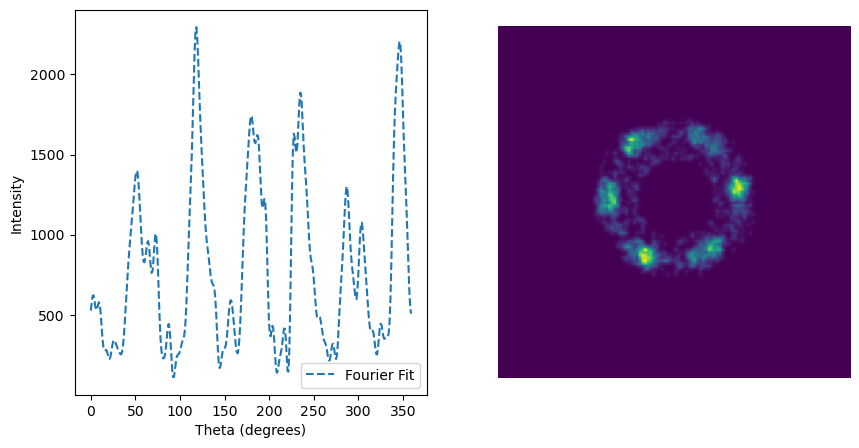

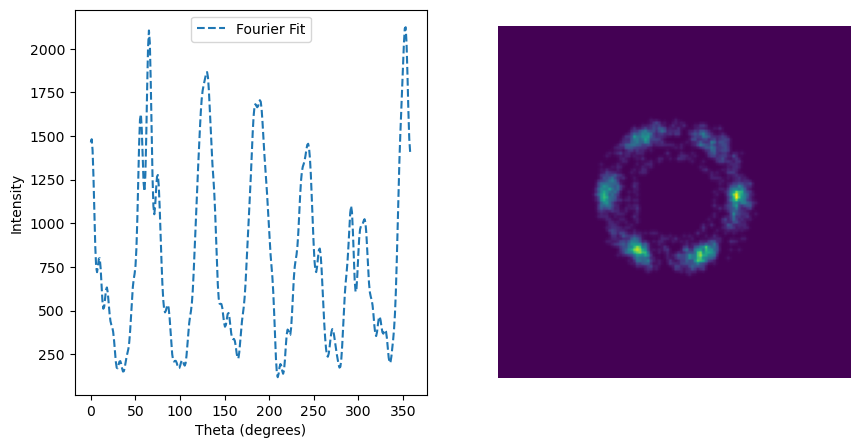

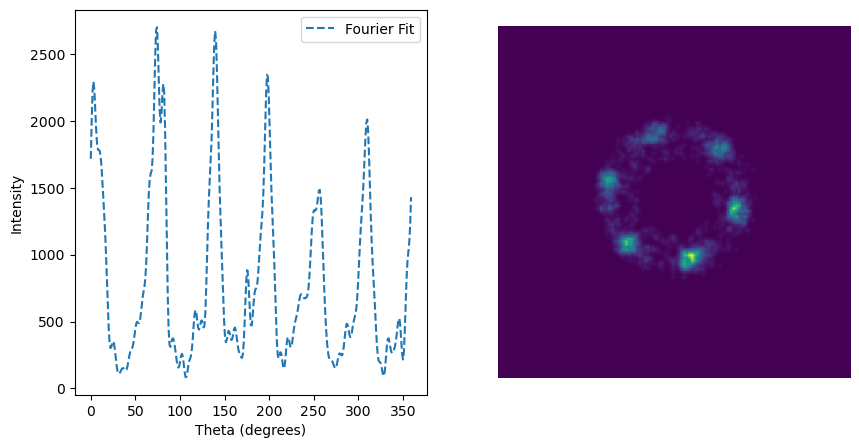

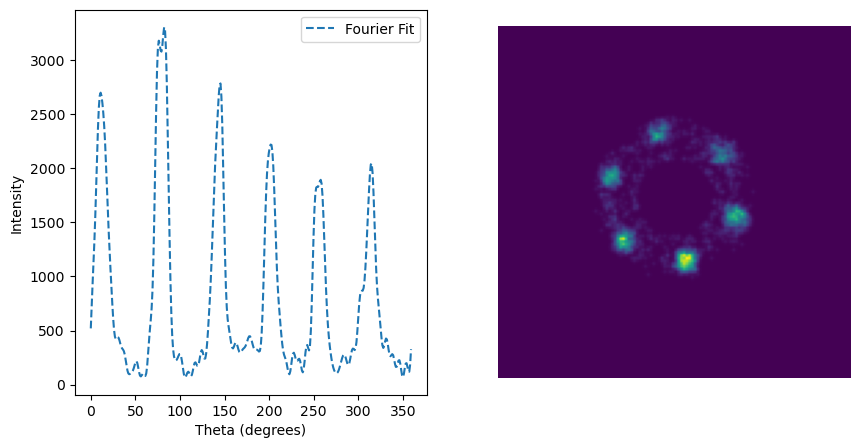

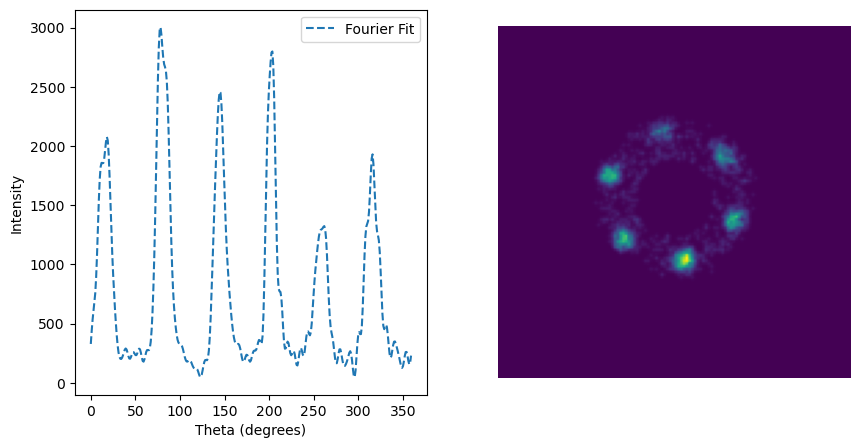

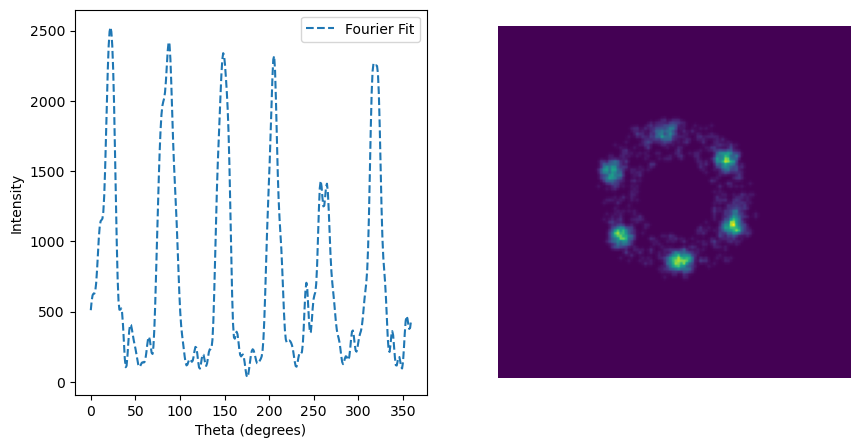

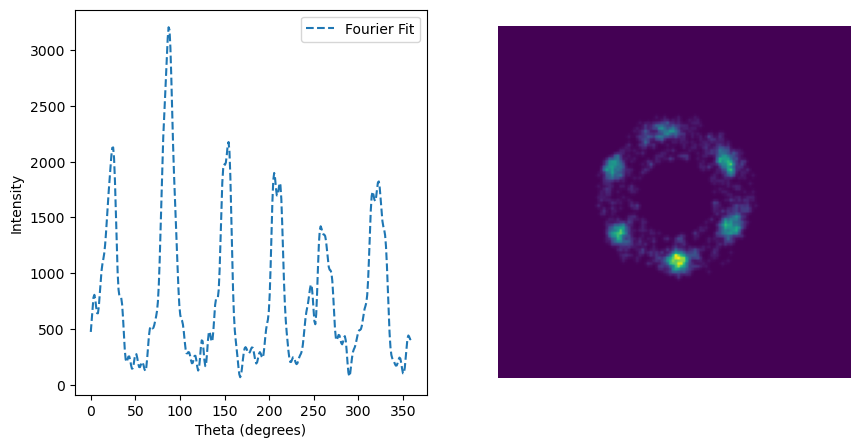

In [85]:
# FITTING WITH FOURIER SERIES

# Define the Fourier series function with N terms
def fourier_series(theta, *coeffs):
    # The number of coefficients should be even: a0 + a1*cos(θ) + b1*sin(θ) + ...
    # First coefficient is a0
    a0 = coeffs[0]
    result = a0 * np.ones_like(theta)
    
    # Add N sine and cosine terms
    num_terms = (len(coeffs) - 1) // 2
    for n in range(1, num_terms + 1):
        result += coeffs[2 * n - 1] * np.cos(n * np.radians(theta))  # cosine term
        result += coeffs[2 * n] * np.sin(n * np.radians(theta))      # sine term
    return result

# Number of terms in the Fourier series (N)
N = 50  # Adjust based on how many terms you want to fit
# Initial guess for the coefficients (a0, a1, b1, a2, b2, ...)
initial_guess = [0] * (2 * N + 1)  # 2N + 1 coefficients for N terms

# Example data (replace this with your intensity and theta data)
for i in range(10):
    theta_values, intensity_values = get_intensity_vs_theta(intensity_data[i])
    popt, _ = curve_fit(fourier_series, theta_values, intensity_values, p0=initial_guess)
    fitted_intensity_values = fourier_series(theta_values, *popt)

    # Plot the results
    fig, axes = plt.subplots(1,2, figsize=(10,5))
    # axes[0].plot(theta_values, intensity_values, label="Original Data")
    axes[0].plot(theta_values, fitted_intensity_values, label="Fourier Fit", linestyle='--')
    axes[0].set_xlabel('Theta (degrees)')
    axes[0].set_ylabel('Intensity')
    axes[0].legend()

    axes[1].imshow(intensity_data[i])
    axes[1].axis('off')
    plt.show()

    # popt contains the fitted coefficients (a0, a1, b1, a2, b2, ...)
    # print("Fitted Coefficients:", popt)
